In [1]:
import torch
import torch.nn as nn
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data.sampler import BatchSampler
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
# convert data to torch.FloatTensor
mean, std = 0.1307, 0.3081

train_dataset = datasets.MNIST('../data/', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
                             ]))
test_dataset = datasets.MNIST('../data/', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((mean,), (std,))
                            ]))
n_classes = 10


In [3]:
mnist_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

def extract_embeddings(dataloader, model, max_points=128*20):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((min(len(dataloader.dataset), max_points), 2))
        labels = np.zeros((min(len(dataloader.dataset), max_points)))
        k = 0
        for images, target in dataloader:
            if k>=max_points:
                break
            images = images.to(device)
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
#     plt.figure(figsize=(10,5))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mnist_classes, loc='upper right')

In [4]:
class SiameseMNIST(Dataset):
    """
    Train: For each sample creates randomly a positive or a negative pair
    Test: Creates fixed pairs for testing
    https://github.com/adambielski/siamese-triplet/blob/master/datasets.py
    """

    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset

        self.train = self.mnist_dataset.train
        self.transform = self.mnist_dataset.transform

        if self.train:
            self.train_labels = self.mnist_dataset.train_labels
            self.train_data = self.mnist_dataset.train_data
            self.labels_set = set(self.train_labels.numpy())
            self.label_to_indices = {label: np.where(self.train_labels.numpy() == label)[0]
                                     for label in self.labels_set}
        else:
            # generate fixed pairs for testing
            self.test_labels = self.mnist_dataset.test_labels
            self.test_data = self.mnist_dataset.test_data
            self.labels_set = set(self.test_labels.numpy())
            self.label_to_indices = {label: np.where(self.test_labels.numpy() == label)[0]
                                     for label in self.labels_set}

            random_state = np.random.RandomState(29)

            positive_pairs = [[i,
                               random_state.choice(self.label_to_indices[self.test_labels[i].item()]),
                               1]
                              for i in range(0, len(self.test_data), 2)]

            negative_pairs = [[i,
                               random_state.choice(self.label_to_indices[
                                                       np.random.choice(
                                                           list(self.labels_set - set([self.test_labels[i].item()]))
                                                       )
                                                   ]),
                               0]
                              for i in range(1, len(self.test_data), 2)]
            self.test_pairs = positive_pairs + negative_pairs

    def __getitem__(self, index):
        if self.train:
            target = np.random.randint(0, 2)
            img1, label1 = self.train_data[index], self.train_labels[index].item()
            if target == 1:
                siamese_index = index
                while siamese_index == index:
                    siamese_index = np.random.choice(self.label_to_indices[label1])
            else:
                siamese_label = np.random.choice(list(self.labels_set - set([label1])))
                siamese_index = np.random.choice(self.label_to_indices[siamese_label])
            img2 = self.train_data[siamese_index]
        else:
            img1 = self.test_data[self.test_pairs[index][0]]
            img2 = self.test_data[self.test_pairs[index][1]]
            target = self.test_pairs[index][2]

        img1 = Image.fromarray(img1.numpy(), mode='L')
        img2 = Image.fromarray(img2.numpy(), mode='L')
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        return (img1, img2), target

    def __len__(self):
        return len(self.mnist_dataset)

In [5]:
siamese_train_dataset = SiameseMNIST(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseMNIST(test_dataset)
batch_size = 128
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

/home/nan/anaconda3/envs/pytorch_learn/lib/python3.6/site-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/nan/anaconda3/envs/pytorch_learn/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/nan/anaconda3/envs/pytorch_learn/lib/python3.6/site-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
/home/nan/anaconda3/envs/pytorch_learn/lib/python3.6/site-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


In [6]:
# define the NN architecture
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(kernel_size=2, stride=2))
        self.conv2 = nn.Sequential(
                        nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, padding=1),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Sequential(
                        nn.Linear(in_features=7*7*8, out_features=64),
                        nn.ReLU(inplace=True),
                        nn.Linear(in_features=64, out_features=10),
                        nn.ReLU(inplace=True),
                        nn.Linear(in_features=10, out_features=2))
        

    def forward_helper(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view((-1, 7*7*8))
        x = self.fc(x)
        return x
    
    def forward(self, input_1, input_2):
        return self.forward_helper(input_1), self.forward_helper(input_2)
    
    def get_embedding(self, x):
        return self.forward_helper(x)
    

# # Contrastive loss, from https://gist.github.com/harveyslash/725fcc68df112980328951b3426c0e0b#file-contrastive-loss-py
# class ContrastiveLoss(torch.nn.Module):
#     """
#     Contrastive loss function.
#     Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
#     label = 1 if the two features being compared are different
#     """

#     def __init__(self, margin=1.0):
#         super(ContrastiveLoss, self).__init__()
#         self.margin = margin

#     def forward(self, output1, output2, label):
#         euclidean_distance = F.pairwise_distance(output1, output2)
#         loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
#                                       (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
#         return loss_contrastive


# https://github.com/adambielski/siamese-triplet/blob/master/losses.py
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss
    Takes embeddings of two samples and a target label == 1 if samples are from the same class and label == 0 otherwise
    """

    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = 1e-9

    def forward(self, output1, output2, target, size_average=True):
        distances = (output2 - output1).pow(2).sum(1)  # squared distances
        losses = 0.5 * (target.float() * distances +
                        (1 + -1 * target).float() * F.relu(self.margin - (distances + self.eps).sqrt()).pow(2))
        return losses.mean() if size_average else losses.sum()

In [7]:
model = Model()
contrastive_loss = ContrastiveLoss(margin=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.to(device)
contrastive_loss.to(device)
print(model)
print(contrastive_loss)

Model(
  (conv1): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=392, out_features=64, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=64, out_features=10, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=10, out_features=2, bias=True)
  )
)
ContrastiveLoss()


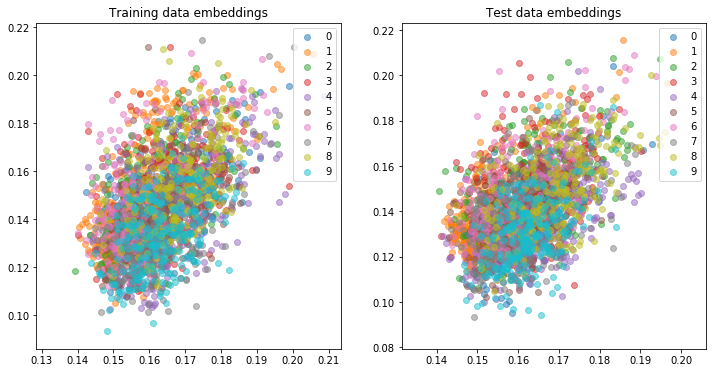

In [8]:
import os
plt.figure(figsize=(12,6))
train_embeddings_cl, train_labels_cl = extract_embeddings(train_loader, model)
plt.subplot(1,2,1)
plot_embeddings(train_embeddings_cl, train_labels_cl)
plt.title('Training data embeddings')
val_embeddings_cl, val_labels_cl = extract_embeddings(test_loader, model)
plt.subplot(1,2,2)
plot_embeddings(val_embeddings_cl, val_labels_cl)
plt.title('Test data embeddings')
plt.savefig(os.path.join("results_siamese","Epoch_{}.png".format(0)))
plt.show()

Epoch: 1 	Training Loss: 8.126138 	Time: 13.572942


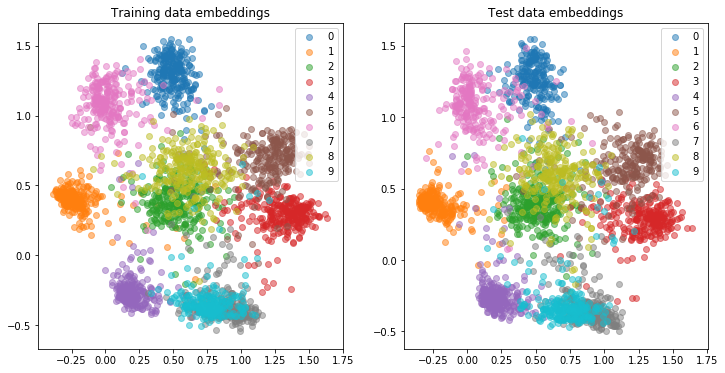

Epoch: 2 	Training Loss: 4.389373 	Time: 15.320198


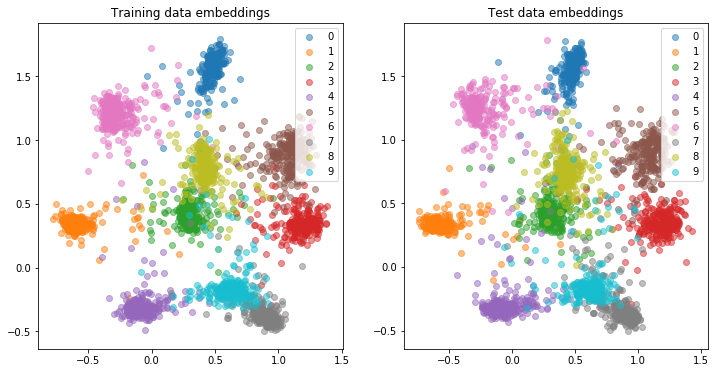

Epoch: 3 	Training Loss: 3.387525 	Time: 14.454393


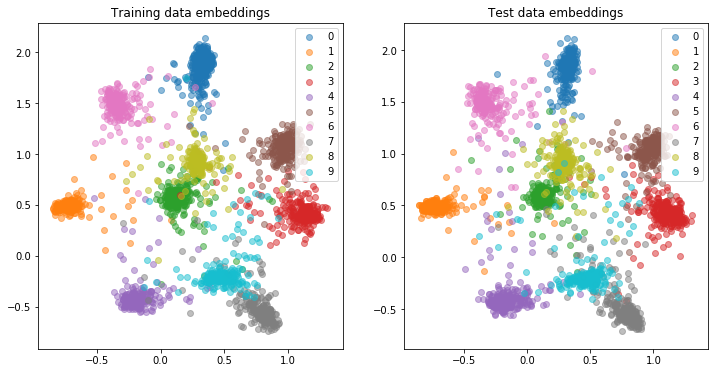

Epoch: 4 	Training Loss: 3.010077 	Time: 14.936120


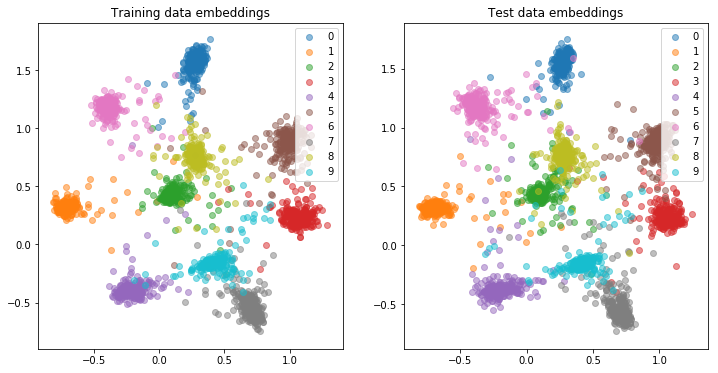

Epoch: 5 	Training Loss: 2.609636 	Time: 14.517805


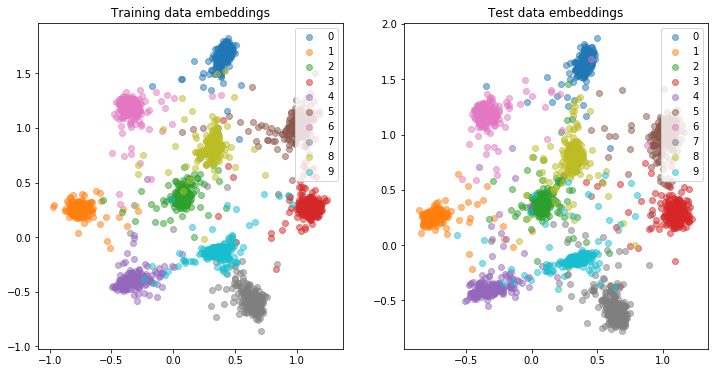

Epoch: 6 	Training Loss: 2.386118 	Time: 15.090936


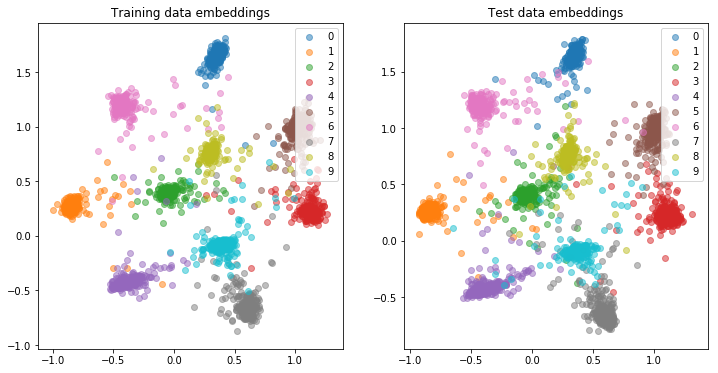

Epoch: 7 	Training Loss: 2.251983 	Time: 14.563914


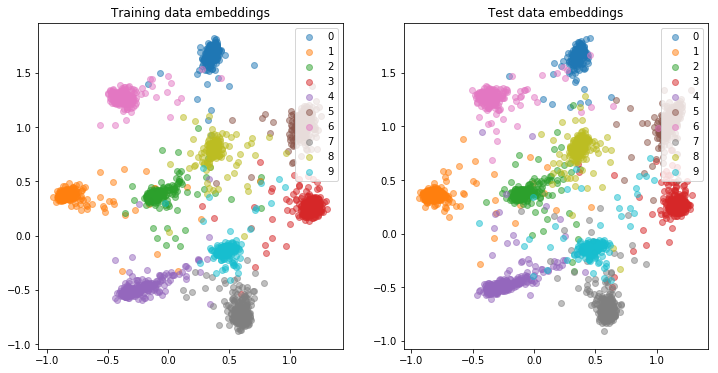

Epoch: 8 	Training Loss: 2.092502 	Time: 14.550291


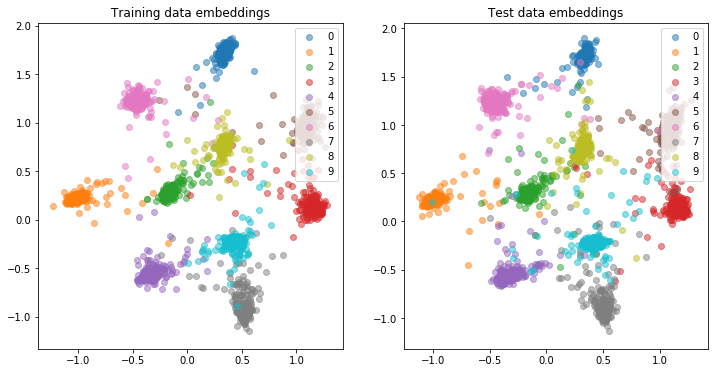

Epoch: 9 	Training Loss: 1.929115 	Time: 14.599858


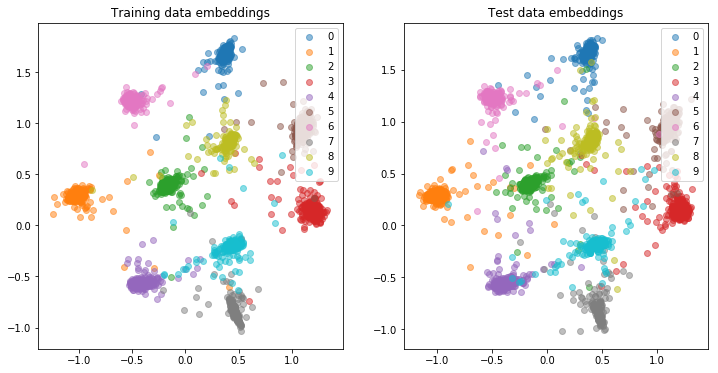

Epoch: 10 	Training Loss: 1.862934 	Time: 14.517526


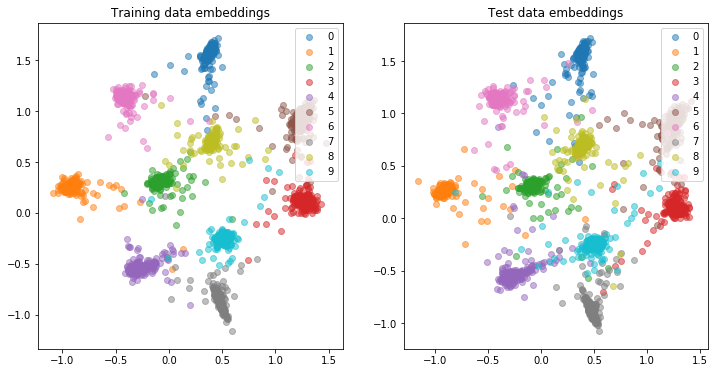

Epoch: 11 	Training Loss: 1.638144 	Time: 15.542026


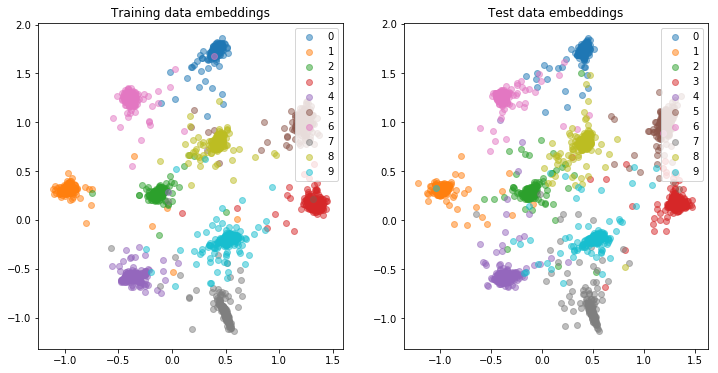

Epoch: 12 	Training Loss: 1.529952 	Time: 15.364019


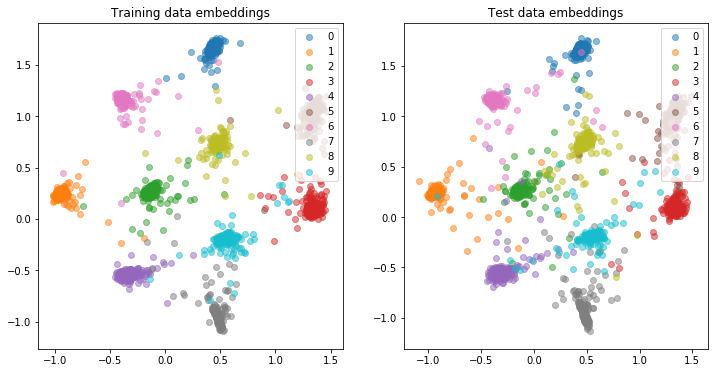

Epoch: 13 	Training Loss: 1.507211 	Time: 14.243299


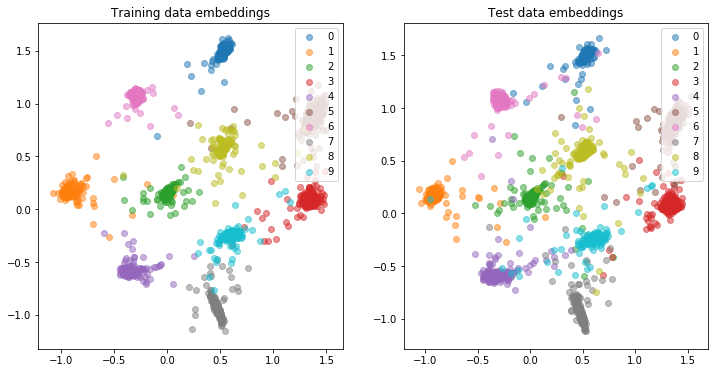

Epoch: 14 	Training Loss: 1.423514 	Time: 14.942490


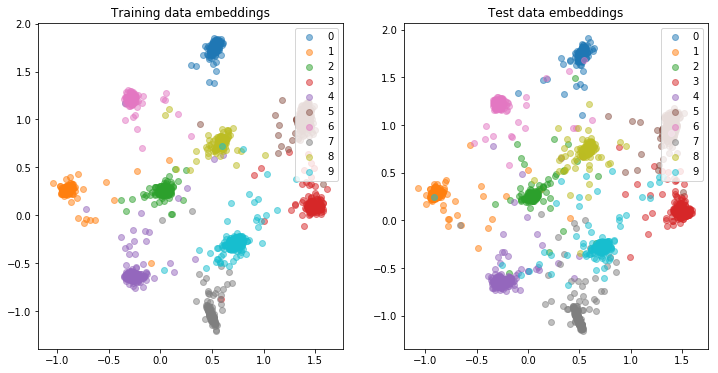

Epoch: 15 	Training Loss: 1.293618 	Time: 15.553648


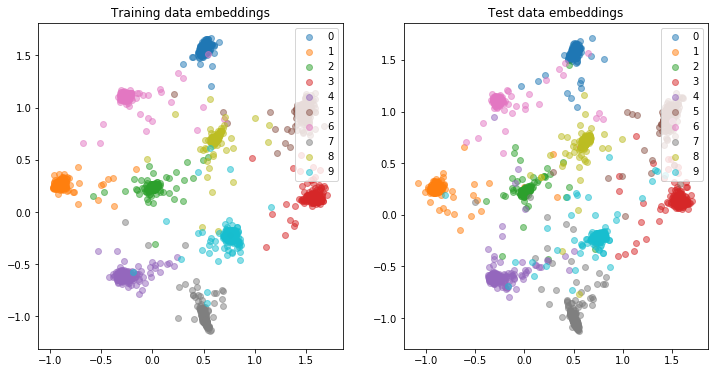

Epoch: 16 	Training Loss: 1.275669 	Time: 15.136598


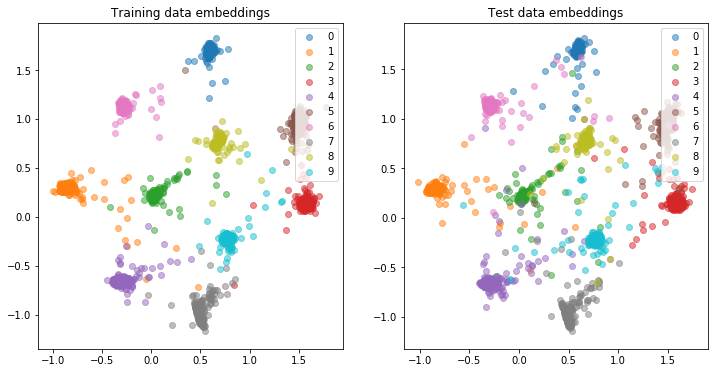

Epoch: 17 	Training Loss: 1.226166 	Time: 15.646472


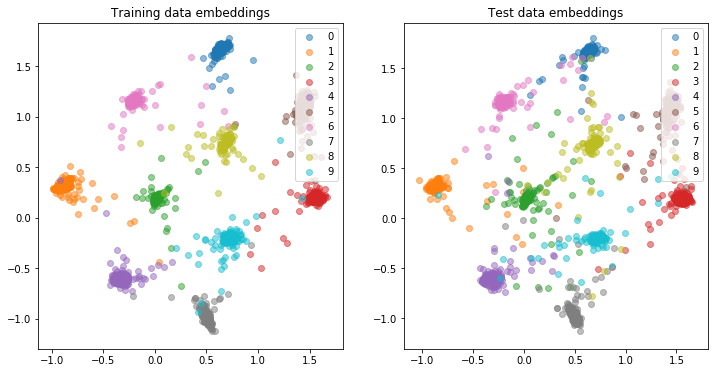

Epoch: 18 	Training Loss: 1.155643 	Time: 16.212209


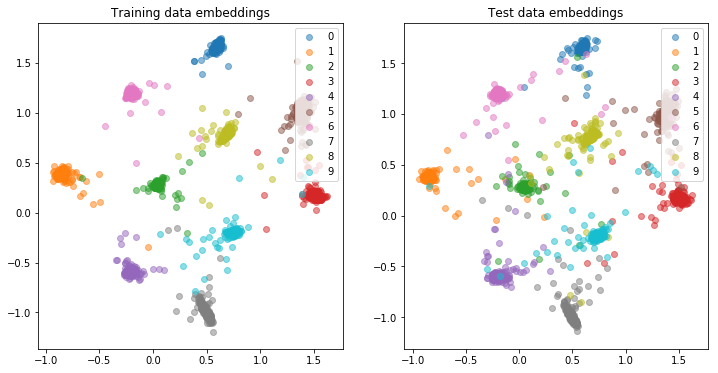

Epoch: 19 	Training Loss: 1.069742 	Time: 15.653989


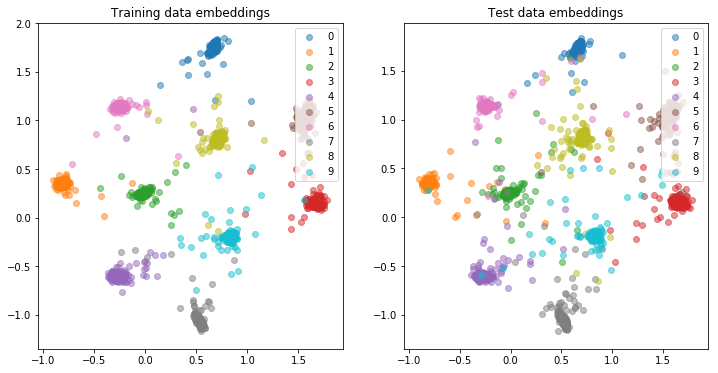

Epoch: 20 	Training Loss: 1.069480 	Time: 15.254870


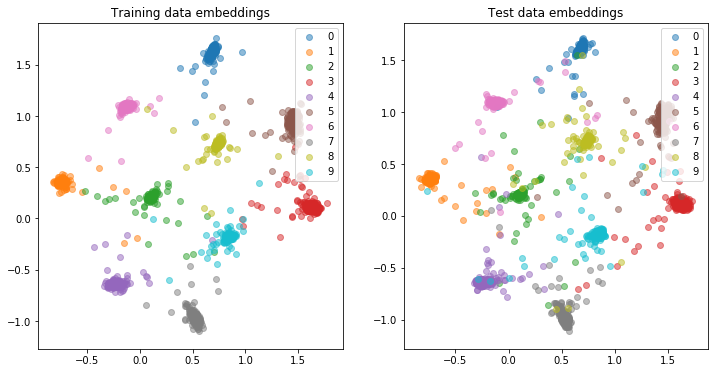

Epoch: 21 	Training Loss: 1.032654 	Time: 15.209690


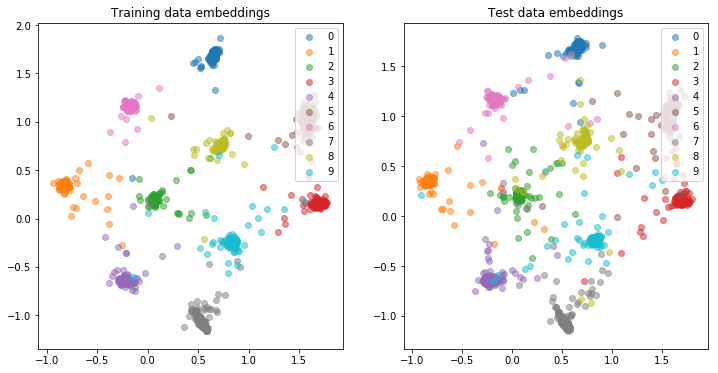

Epoch: 22 	Training Loss: 0.963031 	Time: 15.523092


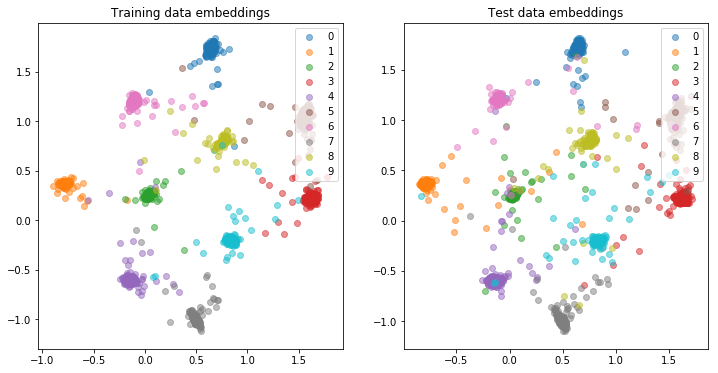

Epoch: 23 	Training Loss: 0.903997 	Time: 15.905882


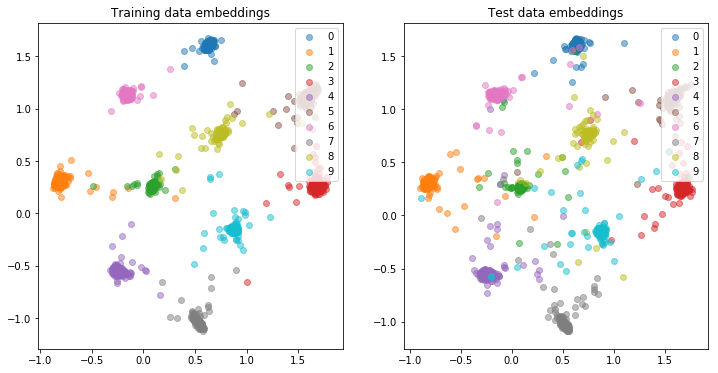

Epoch: 24 	Training Loss: 0.901954 	Time: 15.403869


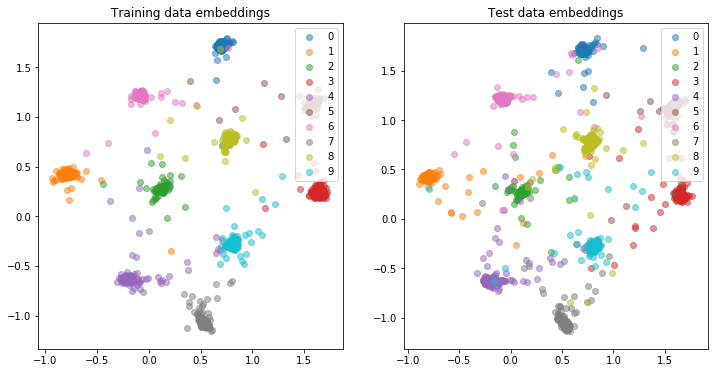

Epoch: 25 	Training Loss: 0.831249 	Time: 15.217787


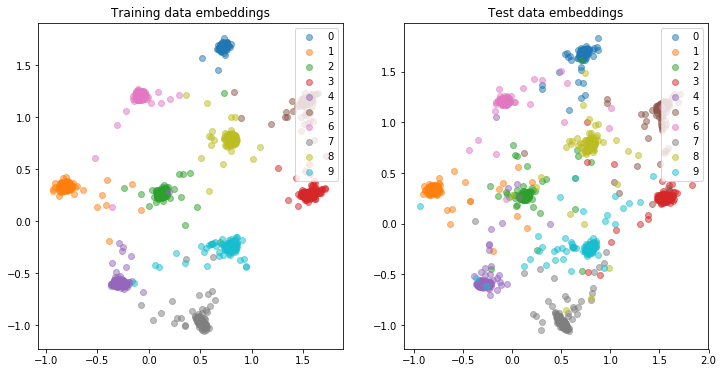

Epoch: 26 	Training Loss: 0.743220 	Time: 15.382628


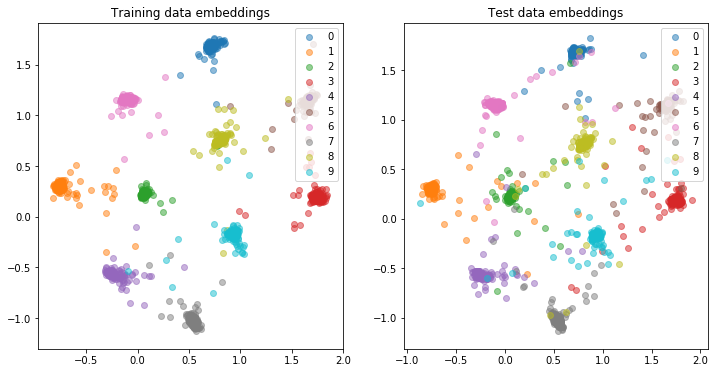

Epoch: 27 	Training Loss: 0.794769 	Time: 15.584442


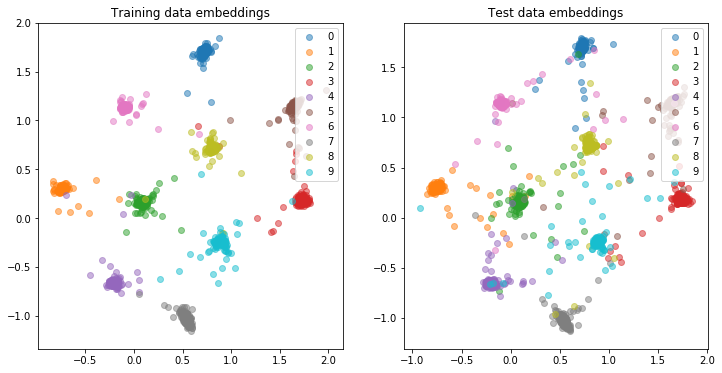

Epoch: 28 	Training Loss: 0.779266 	Time: 15.512913


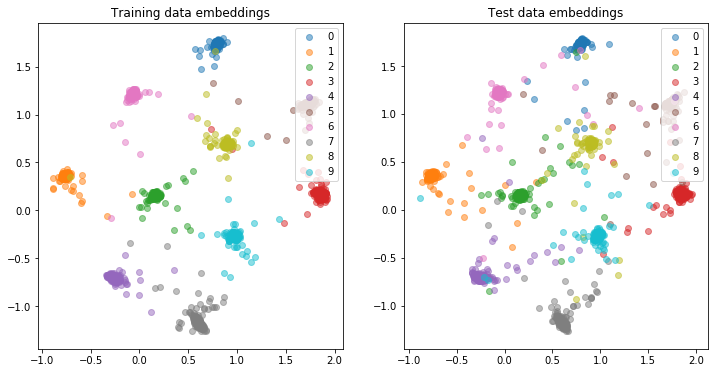

Epoch: 29 	Training Loss: 0.713716 	Time: 15.263602


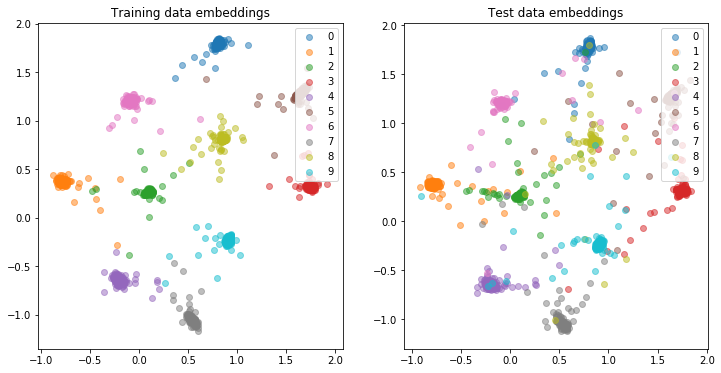

Epoch: 30 	Training Loss: 0.729982 	Time: 15.409771


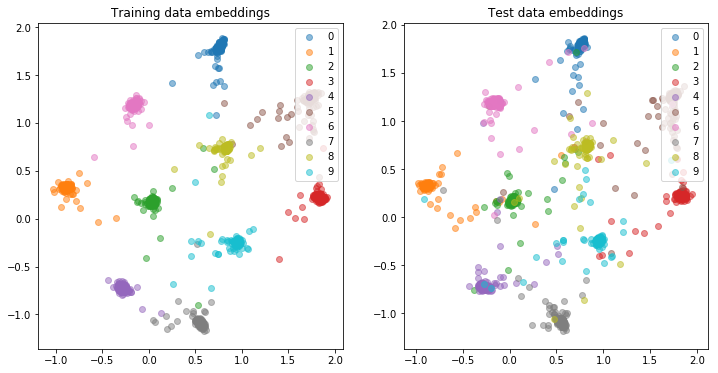

Epoch: 31 	Training Loss: 0.686619 	Time: 15.518613


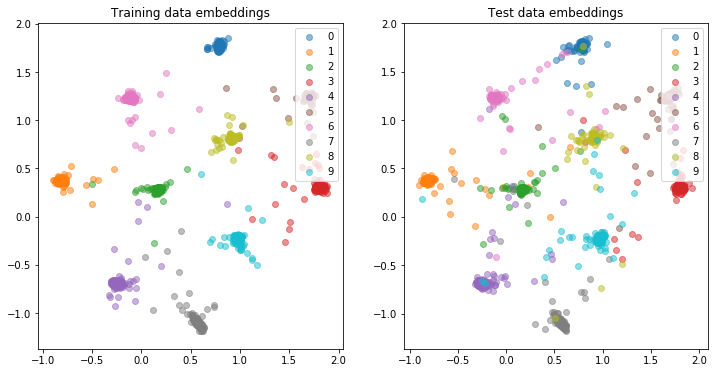

Epoch: 32 	Training Loss: 0.650014 	Time: 15.048287


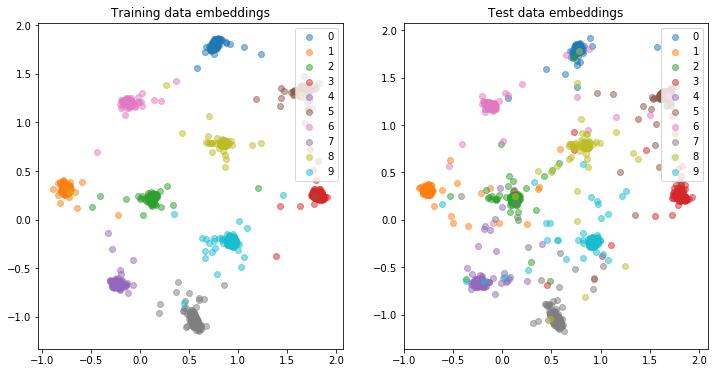

Epoch: 33 	Training Loss: 0.688497 	Time: 14.421791


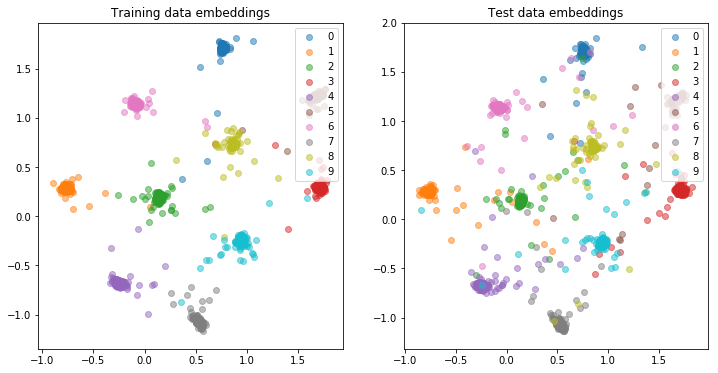

Epoch: 34 	Training Loss: 0.579734 	Time: 15.288675


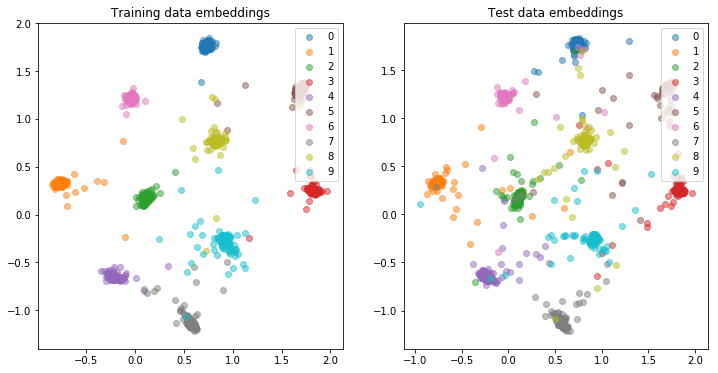

Epoch: 35 	Training Loss: 0.606709 	Time: 15.422282


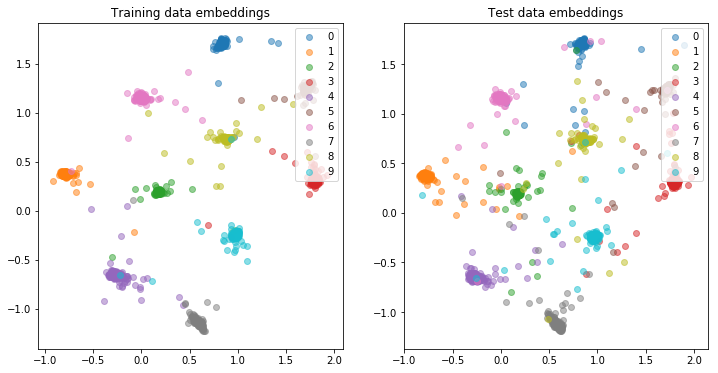

Epoch: 36 	Training Loss: 0.618638 	Time: 14.733282


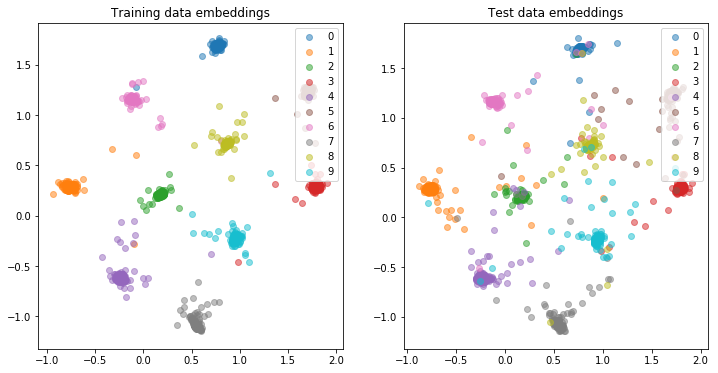

Epoch: 37 	Training Loss: 0.568992 	Time: 15.152291


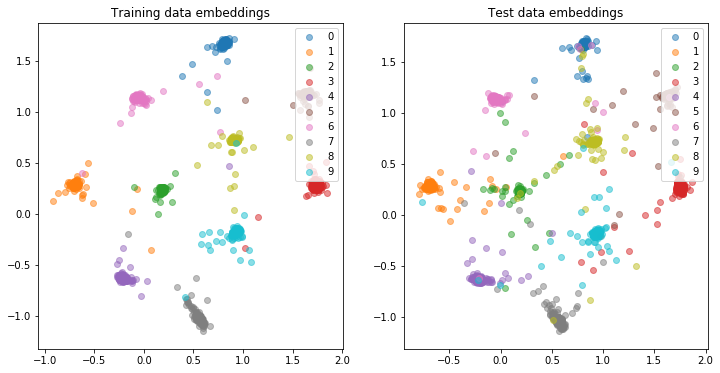

Epoch: 38 	Training Loss: 0.572732 	Time: 14.667534


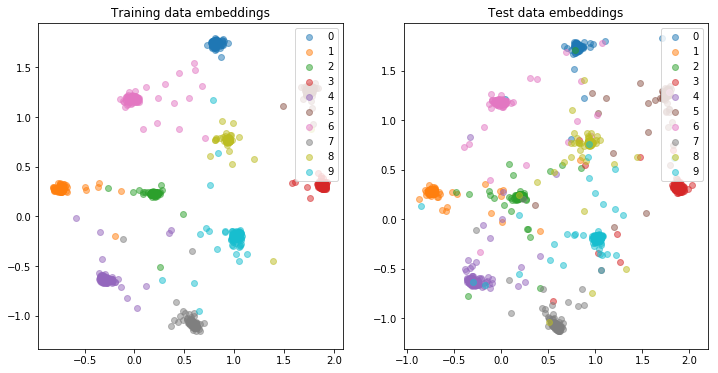

Epoch: 39 	Training Loss: 0.545500 	Time: 14.587441


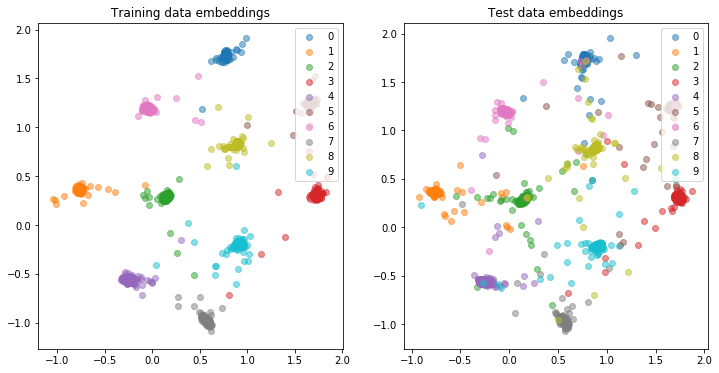

Epoch: 40 	Training Loss: 0.498235 	Time: 15.267015


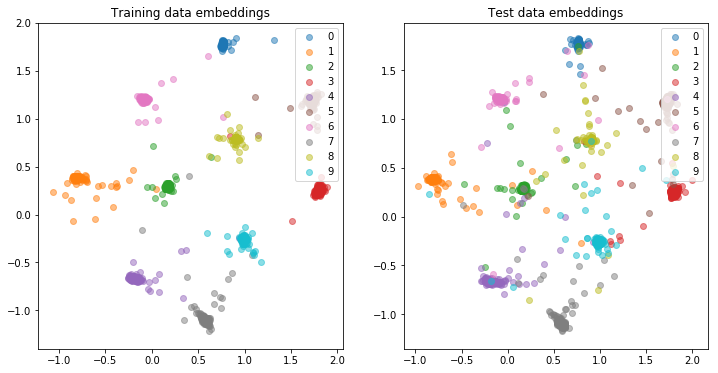

Epoch: 41 	Training Loss: 0.505278 	Time: 14.990068


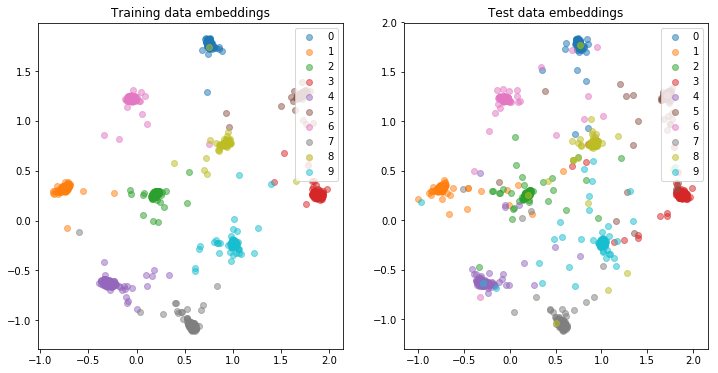

Epoch: 42 	Training Loss: 0.532851 	Time: 15.018741


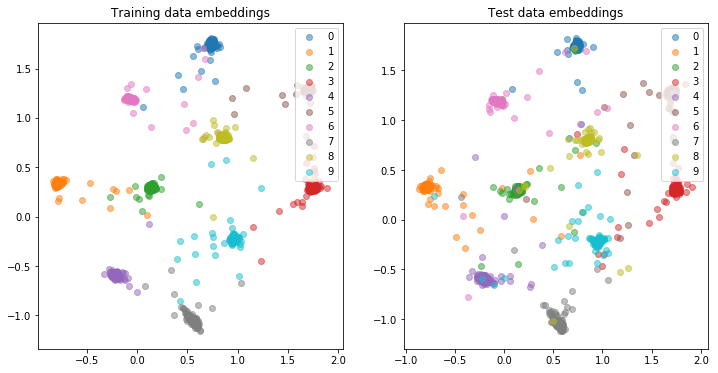

Epoch: 43 	Training Loss: 0.514338 	Time: 14.868463


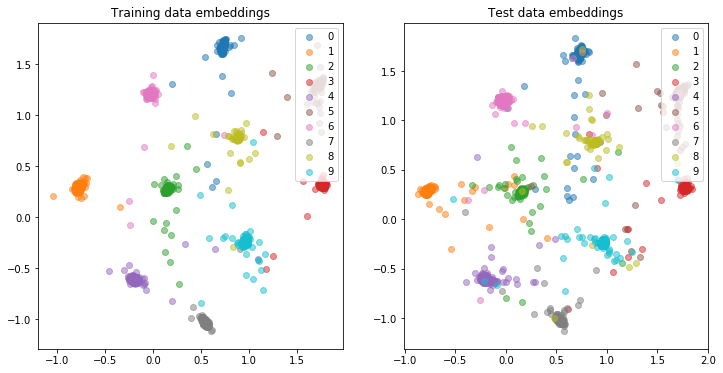

Epoch: 44 	Training Loss: 0.492662 	Time: 14.946770


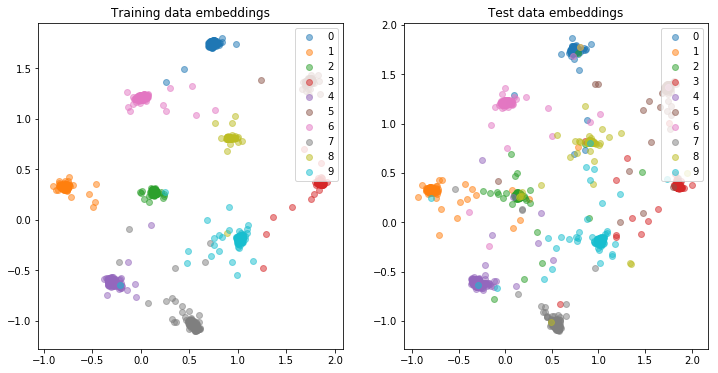

Epoch: 45 	Training Loss: 0.504741 	Time: 14.845560


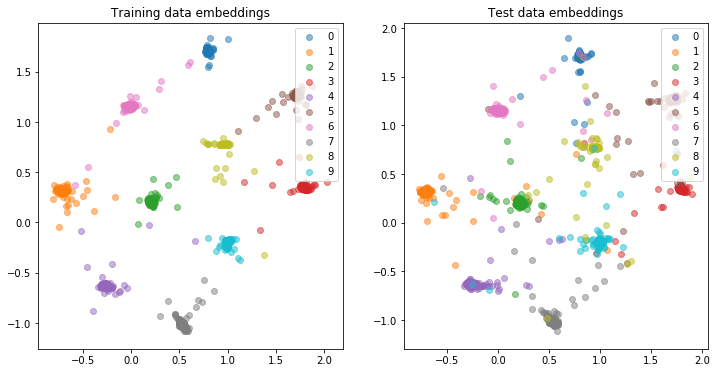

Epoch: 46 	Training Loss: 0.441227 	Time: 14.633929


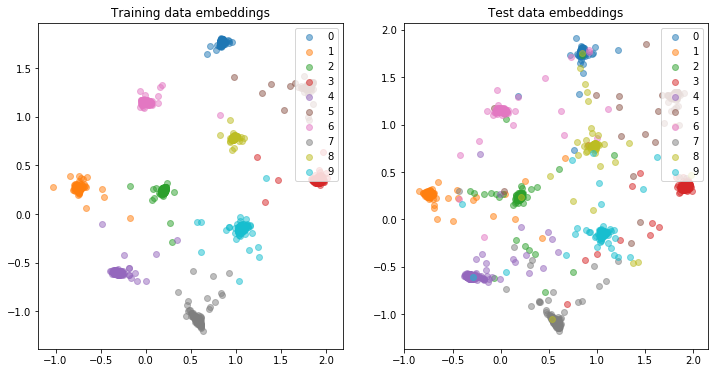

Epoch: 47 	Training Loss: 0.466580 	Time: 14.591155


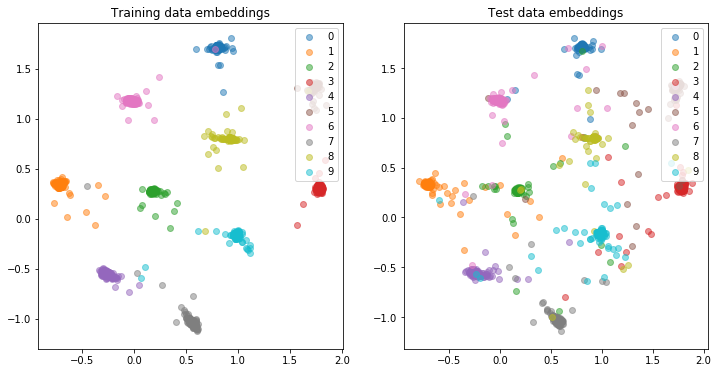

Epoch: 48 	Training Loss: 0.465830 	Time: 14.598042


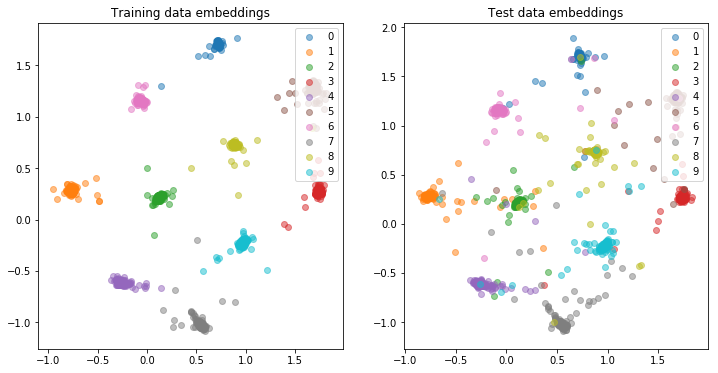

Epoch: 49 	Training Loss: 0.462427 	Time: 14.704023


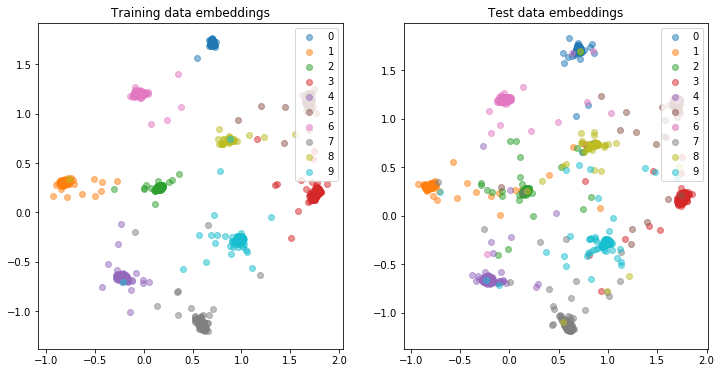

Epoch: 50 	Training Loss: 0.408607 	Time: 15.007861


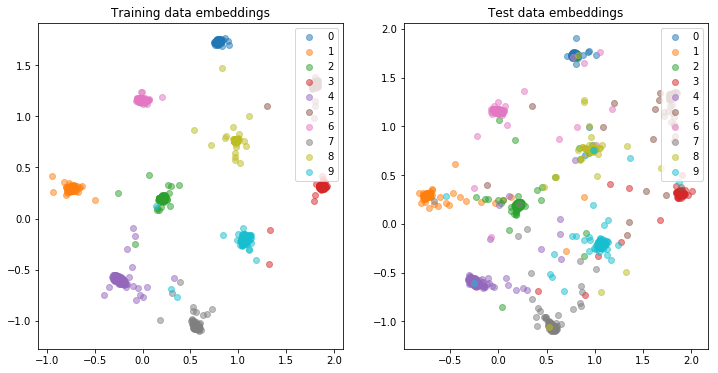

In [9]:
# number of epochs to train the model
n_epochs = 50
import time
dataiter = iter(siamese_test_loader)
prevTime = time.time()
train_loss_hist = []

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    ###################
    # train the model #
    ###################
    for data in siamese_train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        images, target = data
        target = target.float()
        images1, images2 = images
        images1 = images1.to(device)
        images2 = images2.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images1, images2)
        output1, output2 = outputs
        # calculate the loss
#         print(type(output1), type(output2), type(target))
        loss = contrastive_loss(output1, output2, target.to(device))
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images1.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(siamese_train_loader)
    curTime = time.time()
    print('Epoch: {} \tTraining Loss: {:.6f} \tTime: {:.6f}'.format(
        epoch, 
        train_loss,
        curTime-prevTime
        ))
    prevTime = curTime
    train_loss_hist.append(train_loss)
    
    plt.figure(figsize=(12,6))
    train_embeddings_cl, train_labels_cl = extract_embeddings(train_loader, model)
    plt.subplot(1,2,1)
    plot_embeddings(train_embeddings_cl, train_labels_cl)
    plt.title('Training data embeddings')
    val_embeddings_cl, val_labels_cl = extract_embeddings(test_loader, model)
    plt.subplot(1,2,2)
    plot_embeddings(val_embeddings_cl, val_labels_cl)
    plt.title('Test data embeddings')
    plt.savefig(os.path.join("results_siamese","Epoch_{}.png".format(epoch)))
    plt.show()
    print("===========================================================================================")

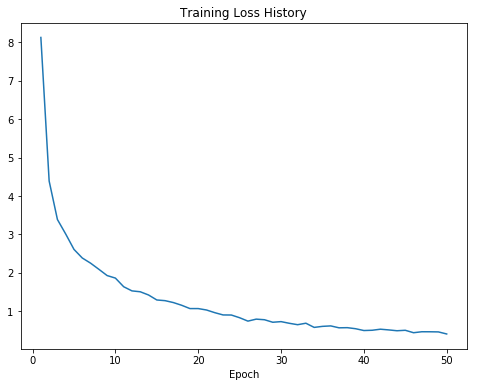

In [10]:
plt.figure(figsize=(8,6))
plt.plot(range(1,len(train_loss_hist)+1), train_loss_hist)
plt.title("Training Loss History")
plt.xlabel('Epoch')
plt.savefig(os.path.join("results_siamese","Training Loss.png"))

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
embeddings, labels = extract_embeddings(train_loader, model)
# clf = DecisionTreeClassifier()
clf = LogisticRegression(solver='lbfgs', multi_class='auto')
clf.fit(embeddings, labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [12]:
test_embeddings, test_labels = extract_embeddings(test_loader, model)
test_pred = clf.predict(test_embeddings)
print("Test accuracy using simple classifier on embeddings: {}%".format(100*sum(test_pred==test_labels)/len(test_pred)))

Test accuracy using simple classifier on embeddings: 96.71875%


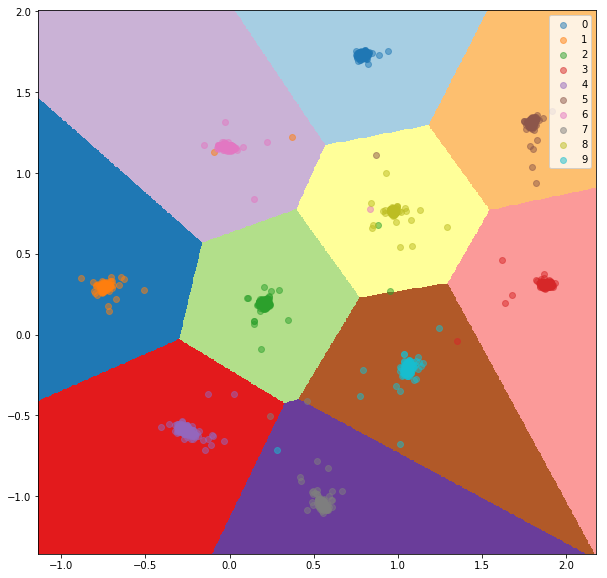

In [13]:
x_min, x_max = min(embeddings[:,0])-0.25, max(embeddings[:,0])+0.25
y_min, y_max = min(embeddings[:,1])-0.25, max(embeddings[:,1])+0.25
h = 0.005
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
X = np.c_[xx.ravel(), yy.ravel()]
Z = clf.predict(X)
Z = Z.reshape(xx.shape)
plt.figure(figsize=(10,10))

plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plot_embeddings(embeddings, labels)
plt.savefig(os.path.join("results_siamese","Simple Classifier.png".format(epoch)))